# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade --no-cache-dir gdown
!rm ~/.cache/gdown/cookies.json
!gdown --id 11OiqJOn6Z0Zgce_dWW--1OnoBYadcawQ
!unzip data.zip
!rm data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/0789bed99cb8_11.jpg  
  inflating: data/train/0789bed99cb8_12.jpg  
  inflating: data/train/0789bed99cb8_13.jpg  
  inflating: data/train/0789bed99cb8_14.jpg  
  inflating: data/train/0789bed99cb8_15.jpg  
  inflating: data/train/0789bed99cb8_16.jpg  
  inflating: data/train/0795e132d090_01.jpg  
  inflating: data/train/0795e132d090_02.jpg  
  inflating: data/train/0795e132d090_03.jpg  
  inflating: data/train/0795e132d090_04.jpg  
  inflating: data/train/0795e132d090_05.jpg  
  inflating: data/train/0795e132d090_06.jpg  
  inflating: data/train/0795e132d090_07.jpg  
  inflating: data/train/0795e132d090_08.jpg  
  inflating: data/train/0795e132d090_09.jpg  
  inflating: data/train/0795e132d090_10.jpg  
  inflating: data/train/0795e132d090_11.jpg  
  inflating: data/train/0795e132d090_12.jpg  
  inflating: data/train/0795e132d090_13.jpg  
  inflating: data/train/0795e132d090_14.jpg  
  inflating:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

#Dataset


In [5]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

In [6]:
df = pd.read_csv('data/train_masks.csv')
df.shape

(5088, 2)

In [7]:
train_df = df[:4000]
val_df = df[4000:].reset_index(drop=True)

In [8]:
df[:5]

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [9]:
img_name, mask_rle = train_df.iloc[1201]

img = cv2.imread('data/train/{}'.format(img_name))
mask = rle_decode(mask_rle)

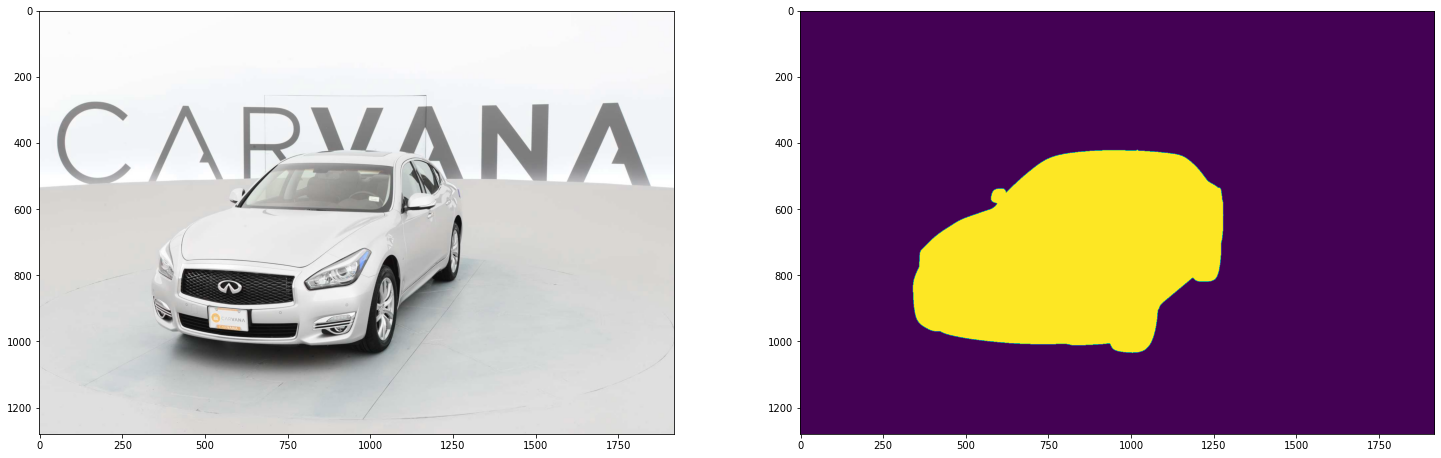

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)

axes[1].imshow(mask[..., 0])

plt.show()

In [11]:
class SegDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transforms_x = nn.Sequential(
            T.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name, mask_rle = self.dataset.iloc[idx].values
        img = cv2.imread('data/train/{}'.format(img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = T.functional.to_tensor(img)
        img = self.transforms_x(img)
        
        mask = rle_decode(mask_rle)
        mask = cv2.resize(mask, (256, 256))
        mask = np.expand_dims(mask, 0)
        mask = torch.from_numpy(mask)

        return img, mask

In [12]:
for x, y in SegDataset(train_df):
    break

In [13]:
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [14]:
(y>0.5).sum()

tensor(11610)

In [15]:
np.unique(y.detach().cpu().numpy())

array([0, 1], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


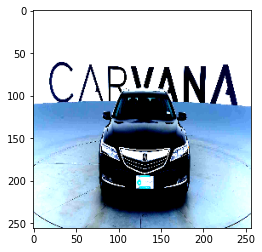

In [16]:
plt.imshow(x.numpy().astype(float).transpose(1, 2, 0))

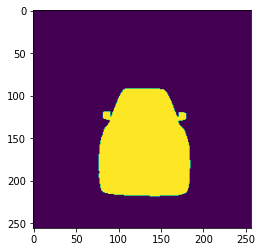

In [17]:
plt.imshow(y.numpy().transpose(1, 2, 0).reshape(256, 256))

In [18]:
x.shape

torch.Size([3, 256, 256])

In [19]:
y.shape

torch.Size([1, 256, 256])

In [20]:
train_dataloader = DataLoader(SegDataset(train_df), batch_size=1)

In [21]:
for x, y in train_dataloader:
    break

In [22]:
x.shape, y.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

In [23]:
(y>0.5).sum()

tensor(11610)

# FCN

![](https://sun9-19.userapi.com/impg/frpAuMfEsGsd8a2QMIiQ8SoKlCj5Zjl0qYpz7w/J82DLbwwOcQ.jpg?size=1159x585&quality=96&sign=a0c5dfedce941cb8ae3bf6ce8e8932e2&type=album)

In [ ]:
import torchvision.models as models

base_model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
base_model(x.float())

tensor([[-1.6687e+00, -3.5213e+00, -3.2557e-01, -3.0048e+00, -3.0083e+00,
         -1.1118e+00, -2.6903e+00,  2.2136e-01, -3.4226e+00, -4.3985e+00,
         -3.1963e+00, -9.6790e-01, -8.7999e-01, -3.9589e+00, -1.2197e+00,
         -2.0853e+00, -2.4658e+00, -9.1332e-02,  1.1771e-01, -1.9826e+00,
         -3.7323e+00, -2.1522e+00, -1.5914e+00,  1.1505e+00, -3.0496e+00,
         -3.4763e+00, -4.6935e+00, -3.5918e+00, -2.9671e+00, -3.8447e+00,
         -1.3342e+00, -3.6129e+00, -2.8309e+00, -3.0018e+00, -2.1705e+00,
          7.5459e-01,  2.6255e-01, -7.6319e-01, -4.3393e+00, -4.9478e-01,
         -1.9170e+00, -2.7632e+00, -3.4781e+00, -3.8275e+00, -3.2330e+00,
         -2.0343e+00, -1.9348e+00, -3.0933e+00, -1.9607e+00, -3.5168e+00,
         -3.5591e+00, -3.5270e+00, -3.1205e+00, -1.6460e+00, -1.3348e+00,
         -2.1630e+00, -3.7155e+00, -2.6349e+00,  5.9634e-01, -4.6034e-01,
         -3.8582e-01, -2.1923e+00, -2.6026e+00,  1.1128e-01, -2.0648e+00,
         -8.5388e-01, -3.3554e+00, -2.

In [ ]:
base_model(x.float()).size()

torch.Size([1, 1000])

In [ ]:
base_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in base_model.parameters():
    if hasattr(param, 'requires_grad'):
        param.requires_grad = False

In [ ]:
base_model.features

In [ ]:
base_features = nn.Sequential(base_model.features)

In [ ]:
base_features(x.float()).size()

torch.Size([1, 512, 8, 8])

In [ ]:
list(base_model.classifier.children())[:-1]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False)]

In [ ]:
nn.Sequential(*list(base_model.classifier.children())[:-1])

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
)

In [ ]:
nn.Linear(4096, 2)

Linear(in_features=4096, out_features=2, bias=True)

In [ ]:
256/8

32.0

In [ ]:
class SegNet(nn.Module):
    def __init__(self, features):
        super(SegNet, self).__init__()
        
        self.features = features
        self.pool = nn.AdaptiveAvgPool2d(output_size=(8, 8))
        self.up = nn.UpsamplingBilinear2d(scale_factor = 32)
        self.conv1 = nn.Conv2d(512, 1, (1, 1))
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.up(x)
        x = self.conv1(x)
        output = self.out(x)
        
        return output

In [ ]:
for param in base_features.parameters():
    if hasattr(param, 'requires_grad'):
        param.requires_grad = False

In [ ]:
model = SegNet(base_features)

In [ ]:
base_features(x.float()).size()

torch.Size([1, 512, 8, 8])

In [ ]:
pred = model(x.float())

In [ ]:
pred.shape

torch.Size([1, 1, 256, 256])

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
pred.shape

(1, 1, 256, 256)

In [ ]:
pred[0].transpose((1, 2, 0)).shape

(256, 256, 1)

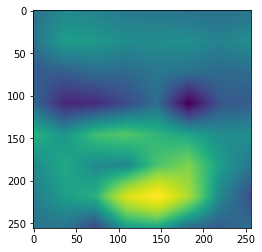

In [ ]:
plt.imshow(pred[0].transpose((1, 2, 0)).reshape(256, 256))

In [ ]:
train_dataloader = DataLoader(SegDataset(train_df), batch_size=16, num_workers=2)
test_dataloader = DataLoader(SegDataset(val_df), batch_size=16, num_workers=2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss(reduction='mean')

device = 'cuda'

if torch.cuda.is_available():
    model.to(device)

In [ ]:
from tqdm.notebook import tqdm
for epoch in range(5):
    model.train()

    for (batch_idx, (data, y)) in tqdm(enumerate(train_dataloader), total = 4000/16):
        if torch.cuda.is_available():
            data = data.to(device).float()
            y = y.to(device).float()

        optimizer.zero_grad()

        ypred = model(data)
        loss = criterion(ypred.float(), 
                         y.float())

        loss.backward()

        optimizer.step()

    print(f"EPOCH {epoch}, Train Loss: {loss.item()}")
    
    if test_dataloader is not None:
        model.eval()
        with torch.no_grad():
            for (batch_idx, (data, y)) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    data = data.to(device).float()
                    y = y.to(device).float()

                ypred = model(data)
                loss = criterion(ypred, y)
    
    print(f"EPOCH {epoch}, Test Loss: {loss.item()}")

  0%|          | 0/250.0 [00:00<?, ?it/s]

EPOCH 0, Train Loss: 0.08229309320449829
EPOCH 0, Test Loss: 0.10818915069103241


  0%|          | 0/250.0 [00:00<?, ?it/s]

EPOCH 1, Train Loss: 0.07814718782901764
EPOCH 1, Test Loss: 0.11326728761196136


  0%|          | 0/250.0 [00:00<?, ?it/s]

EPOCH 2, Train Loss: 0.0775037556886673
EPOCH 2, Test Loss: 0.11528559774160385


  0%|          | 0/250.0 [00:00<?, ?it/s]

EPOCH 3, Train Loss: 0.07773056626319885
EPOCH 3, Test Loss: 0.11608973145484924


  0%|          | 0/250.0 [00:00<?, ?it/s]

EPOCH 4, Train Loss: 0.07810258865356445
EPOCH 4, Test Loss: 0.11636437475681305


In [ ]:
np.unique(y.detach().cpu().numpy()), np.unique(data.detach().cpu().numpy())

(array([0., 1.], dtype=float32),
 array([-2.117904  , -2.1007793 , -2.0836544 , -2.0665298 , -2.0494049 ,
        -2.0357141 , -2.0322802 , -2.0182073 , -2.0151556 , -2.0007002 ,
        -1.9980307 , -1.9831933 , -1.980906  , -1.9656862 , -1.9637812 ,
        -1.9481792 , -1.9466565 , -1.9306722 , -1.9295317 , -1.9131652 ,
        -1.9124069 , -1.8956583 , -1.8952821 , -1.8781574 , -1.8781512 ,
        -1.8610327 , -1.8606442 , -1.843908  , -1.8431373 , -1.8267832 ,
        -1.8256302 , -1.8096584 , -1.8081232 , -1.8044444 , -1.7925336 ,
        -1.7906162 , -1.7870152 , -1.7754089 , -1.7731092 , -1.7695861 ,
        -1.7582842 , -1.7556022 , -1.7521569 , -1.7411594 , -1.7380952 ,
        -1.7347276 , -1.7240347 , -1.7205882 , -1.7172985 , -1.7069099 ,
        -1.7030813 , -1.6998693 , -1.6897851 , -1.6855742 , -1.68244   ,
        -1.6726604 , -1.6680672 , -1.6650109 , -1.6555357 , -1.6505601 ,
        -1.6475817 , -1.6384109 , -1.6330532 , -1.6301525 , -1.6212862 ,
        -1.6155462

In [ ]:
pred = model(data.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([5.6690614e-11, 6.3841904e-11, 6.6024311e-11, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [ ]:
data.shape

torch.Size([16, 3, 256, 256])

In [ ]:
pred.shape

(16, 1, 256, 256)

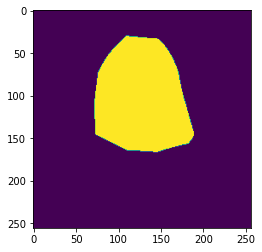

In [ ]:
plt.imshow((pred[0, :, :, :]>0.5).transpose((1, 2, 0)).reshape(256, -1))

In [ ]:
data[3].detach().cpu().numpy().astype(float)

array([[[2.06053591, 2.06053591, 2.06053591, ..., 1.88928843,
         1.88928843, 1.88928843],
        [2.06053591, 2.06053591, 2.06053591, ..., 1.88928843,
         1.88928843, 1.88928843],
        [2.06053591, 2.06053591, 2.06053591, ..., 1.88928843,
         1.88928843, 1.88928843],
        ...,
        [1.49541914, 1.54679334, 1.47829437, ..., 1.66666663,
         1.66666663, 1.66666663],
        [1.42692006, 1.4611696 , 1.56391811, ..., 1.64954185,
         1.66666663, 1.70091617],
        [1.42692006, 1.4611696 , 1.4611696 , ..., 1.64954185,
         1.71804082, 1.70091617]],

       [[2.21848726, 2.21848726, 2.21848726, ..., 1.99089634,
         1.99089634, 1.99089634],
        [2.21848726, 2.21848726, 2.21848726, ..., 1.99089634,
         1.99089634, 1.99089634],
        [2.21848726, 2.21848726, 2.21848726, ..., 1.99089634,
         1.99089634, 1.99089634],
        ...,
        [1.71078432, 1.76330531, 1.69327736, ..., 1.8158263 ,
         1.8158263 , 1.8158263 ],
        [1.6

In [ ]:
pred[0].shape

(1, 256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


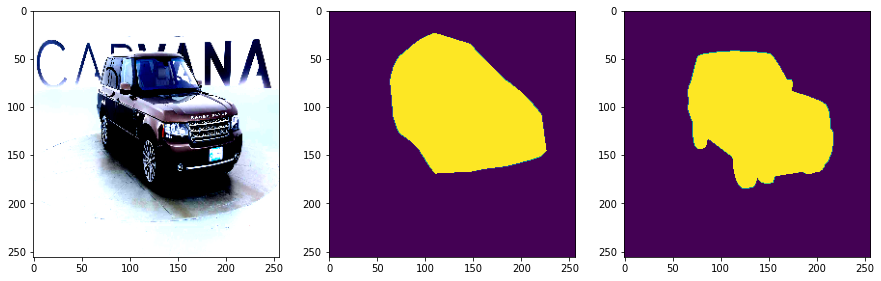

In [ ]:
im_id = 15
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(data[im_id].detach().cpu().numpy().astype(float).transpose((1, 2, 0)))
axes[1].imshow((pred[im_id] > 0.5).transpose((1, 2, 0)).reshape(256, -1))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose((1, 2, 0)).reshape(256, -1))

plt.show()

# SegNet

In [ ]:
new_model = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(32, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(64, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(128, 256, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(256, 128, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(128, 64, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(64, 32, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(32, 1, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(1, 1, (3, 3), padding=1),
    nn.Sigmoid()
    )

In [ ]:
new_model(x.float()).size()

torch.Size([1, 1, 256, 256])

In [ ]:
train_dataloader = DataLoader(SegDataset(train_df), batch_size=16, num_workers=2, drop_last=True)
test_dataloader = DataLoader(SegDataset(val_df), batch_size=16, num_workers=2, drop_last=True)

In [ ]:
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.01)
criterion = nn.BCELoss()

if torch.cuda.is_available():
    new_model.to('cuda')

In [ ]:
for epoch in range(5):
    new_model.train()
    for (batch_idx, (data, y)) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            data = data.to('cuda').float()
            y = y.to('cuda').float()
        
        optimizer.zero_grad()
        
        ypred = new_model(data)
        loss = criterion(ypred, y)

        loss.backward()

        optimizer.step()

    print(f"EPOCH {epoch}, Train Loss: {loss.item()}")
    
    if test_dataloader is not None:
        new_model.eval()
        with torch.no_grad():
            for (batch_idx, (data, y)) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    data = data.to('cuda:0').float()
                    y = y.to('cuda:0').float()

                ypred = new_model(data)
                loss = criterion(ypred, y)
    
    print(f"EPOCH {epoch}, Test Loss: {loss.item()}")

EPOCH 0, Train Loss: 25.925445556640625
EPOCH 0, Test Loss: 24.89032745361328
EPOCH 1, Train Loss: 25.925445556640625
EPOCH 1, Test Loss: 24.89032745361328
EPOCH 2, Train Loss: 25.925445556640625
EPOCH 2, Test Loss: 24.89032745361328
EPOCH 3, Train Loss: 25.925445556640625
EPOCH 3, Test Loss: 24.89032745361328
EPOCH 4, Train Loss: 25.925445556640625
EPOCH 4, Test Loss: 24.89032745361328


In [ ]:
np.unique(y.detach().cpu().numpy()), np.unique(data.detach().cpu().numpy())

(array([0., 1.], dtype=float32),
 array([-2.117904  , -2.1007793 , -2.0836544 , -2.0665298 , -2.0494049 ,
        -2.0357141 , -2.0322802 , -2.0182073 , -2.0151556 , -2.0007002 ,
        -1.9980307 , -1.9831933 , -1.980906  , -1.9656862 , -1.9637812 ,
        -1.9481792 , -1.9466565 , -1.9306722 , -1.9295317 , -1.9131652 ,
        -1.9124069 , -1.8956583 , -1.8952821 , -1.8781574 , -1.8781512 ,
        -1.8610327 , -1.8606442 , -1.843908  , -1.8431373 , -1.8267832 ,
        -1.8256302 , -1.8096584 , -1.8081232 , -1.8044444 , -1.7925336 ,
        -1.7906162 , -1.7870152 , -1.7754089 , -1.7731092 , -1.7695861 ,
        -1.7582842 , -1.7556022 , -1.7521569 , -1.7411594 , -1.7380952 ,
        -1.7347276 , -1.7240347 , -1.7205882 , -1.7172985 , -1.7069099 ,
        -1.7030813 , -1.6998693 , -1.6897851 , -1.6855742 , -1.68244   ,
        -1.6726604 , -1.6680672 , -1.6650109 , -1.6555357 , -1.6505601 ,
        -1.6475817 , -1.6384109 , -1.6330532 , -1.6301525 , -1.6212862 ,
        -1.6155462

In [ ]:
pred = new_model(data.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([0.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


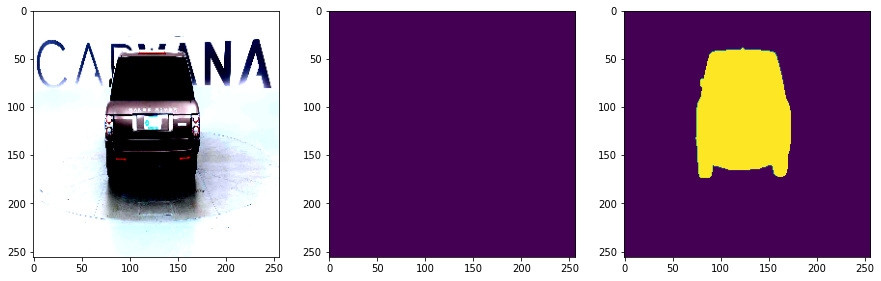

In [ ]:
im_id = 8
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(data[im_id].detach().cpu().numpy().astype(float).transpose((1, 2, 0)))
axes[1].imshow((pred[im_id]).transpose(1, 2, 0).reshape(256, -1))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose(1, 2, 0).reshape(256, -1))

plt.show()

In [ ]:
new_model_bn = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(32, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(64, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(128, 256, (3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, (3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(256, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(128, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(64, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(32, 1, (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(1, 1, (3, 3), padding=1)
    )

In [ ]:
new_model_bn(x.float()).size()

torch.Size([1, 1, 256, 256])

In [ ]:
train_dataloader = DataLoader(SegDataset(train_df), batch_size=32, num_workers=2, drop_last=True)
test_dataloader = DataLoader(SegDataset(val_df), batch_size=32, num_workers=2, drop_last=True)

In [ ]:
optimizer = torch.optim.Adam(new_model_bn.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    new_model_bn.to('cuda')

In [ ]:
scaler = torch.cuda.amp.GradScaler()
for epoch in range(5):
    new_model_bn.train()
    for (batch_idx, (data, y)) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            data = data.to('cuda').float()
            y = y.to('cuda').float()

        optimizer.zero_grad()

        # Casts operations to mixed precision
        with torch.cuda.amp.autocast():
            ypred = new_model_bn(data)
            loss = criterion(ypred, y)

        # Scales the loss, and calls backward()
        # to create scaled gradients
#             loss.backward()
        scaler.scale(loss).backward()

        # Unscales gradients and calls
        # or skips optimizer.step()
#             optimizer.step()
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()

    print(f"EPOCH {epoch}, Train Loss: {loss.item()}")
    
    if test_dataloader is not None:
        new_model_bn.eval()
        with torch.no_grad():
            for (batch_idx, (data, y)) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    data = data.to('cuda:0').float()
                    y = y.to('cuda:0').float()
                
                with torch.cuda.amp.autocast():
                    ypred = new_model_bn(data)
                    loss = criterion(ypred, y)
    
    print(f"EPOCH {epoch}, Test Loss: {loss.item()}")

EPOCH 0, Train Loss: 0.24380198121070862
EPOCH 0, Test Loss: 0.2287316769361496
EPOCH 1, Train Loss: 0.144976407289505
EPOCH 1, Test Loss: 0.15257957577705383
EPOCH 2, Train Loss: 0.0979614108800888
EPOCH 2, Test Loss: 0.1285219043493271
EPOCH 3, Train Loss: 0.07293777912855148
EPOCH 3, Test Loss: 0.08065652847290039
EPOCH 4, Train Loss: 0.05560976266860962
EPOCH 4, Test Loss: 0.06230318546295166


In [ ]:
np.unique(y.detach().cpu().numpy()), np.unique(data.detach().cpu().numpy())

(array([0., 1.], dtype=float32),
 array([-2.117904  , -2.1007793 , -2.0836544 , -2.0665298 , -2.0494049 ,
        -2.0357141 , -2.0322802 , -2.0182073 , -2.0151556 , -2.0007002 ,
        -1.9980307 , -1.9831933 , -1.980906  , -1.9656862 , -1.9637812 ,
        -1.9481792 , -1.9466565 , -1.9306722 , -1.9295317 , -1.9131652 ,
        -1.9124069 , -1.8956583 , -1.8952821 , -1.8781574 , -1.8781512 ,
        -1.8610327 , -1.8606442 , -1.843908  , -1.8431373 , -1.8267832 ,
        -1.8256302 , -1.8096584 , -1.8081232 , -1.8044444 , -1.7925336 ,
        -1.7906162 , -1.7870152 , -1.7754089 , -1.7731092 , -1.7695861 ,
        -1.7582842 , -1.7556022 , -1.7521569 , -1.7411594 , -1.7380952 ,
        -1.7347276 , -1.7240347 , -1.7205882 , -1.7172985 , -1.7069099 ,
        -1.7030813 , -1.6998693 , -1.6897851 , -1.6855742 , -1.68244   ,
        -1.6726604 , -1.6680672 , -1.6650109 , -1.6555357 , -1.6505601 ,
        -1.6475817 , -1.6384109 , -1.6330532 , -1.6301525 , -1.6212862 ,
        -1.6155462

In [ ]:
pred = new_model_bn(data.float().to('cuda'))

In [ ]:
pred = pred.detach().cpu().numpy()

In [ ]:
np.unique(pred)

array([-3.4668639, -3.465576 , -3.4648361, ..., 12.598365 , 12.605471 ,
       12.6064   ], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


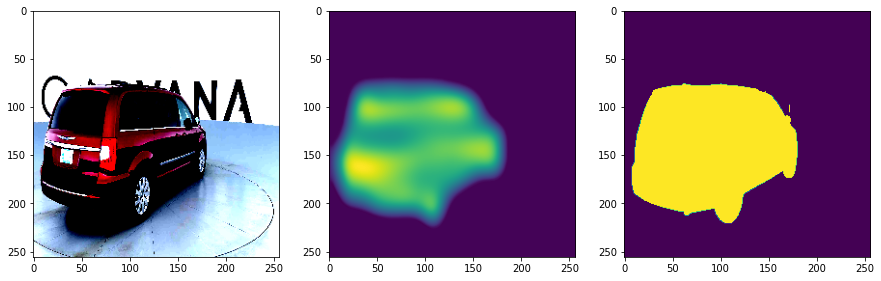

In [ ]:
im_id = 10
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(data[im_id].detach().cpu().numpy().astype(float).transpose((1, 2, 0)))
axes[1].imshow((pred[im_id]).transpose((1, 2, 0)).reshape(256, 256))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose((1, 2, 0)).reshape(256, 256))

plt.show()

In [ ]:
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
output = m(input)
print(output.shape)

torch.Size([20, 33, 26, 100])


# Vanilla Unet

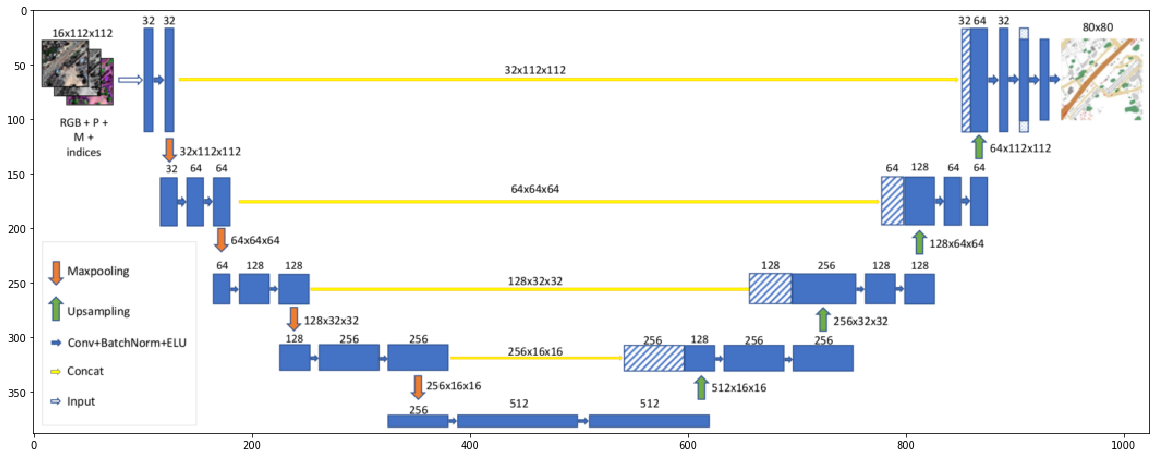

In [ ]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

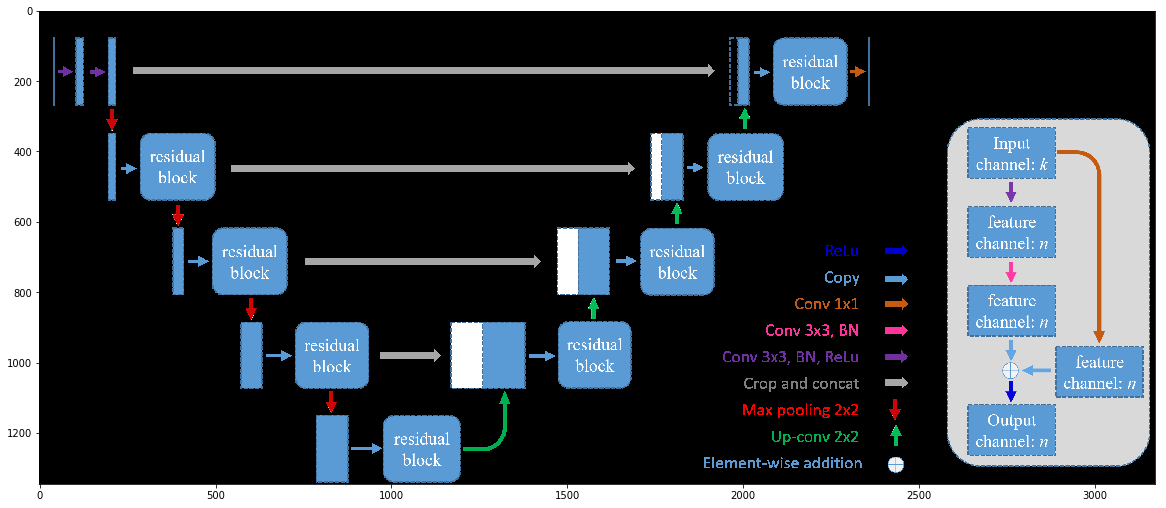

In [ ]:
seg_png = cv2.imread('unet_resnet_strucutre_new.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
!pip install -U segmentation-models-pytorch albumentations

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(height=256, width=256, always_apply=True),

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height=256, width=256, always_apply=True),
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.shape[2]>1:
          plt.imshow(image.reshape(256, 256, -1))
        else:
          plt.imshow(image.reshape(256, 256))
    plt.show()

In [ ]:
class SegDataset(Dataset):
    def __init__(
            self, 
            dataset, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.dataset = dataset
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # read data
        img_name, mask_rle = self.dataset.iloc[i].values
        image = cv2.imread('data/train/{}'.format(img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = rle_decode(mask_rle)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.dataset)

In [ ]:
augmented_dataset = SegDataset(
    train_df, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[55]
    visualize(image=image, mask=mask)

Exception: ignored

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext50_32x4d' 
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [ ]:
train_dataset = SegDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)
test_dataset = SegDataset(
    val_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 272/272 [01:02<00:00,  4.32it/s, dice_loss - 0.05725, iou_score - 0.9655]
Model saved!

Epoch: 1
valid: 100%|██████████| 272/272 [01:03<00:00,  4.32it/s, dice_loss - 0.02475, iou_score - 0.978]
Model saved!

Epoch: 2
train:  38%|███▊      | 188/500 [03:22<05:36,  1.08s/it, dice_loss - 0.02518, iou_score - 0.9712]


KeyboardInterrupt: ignored

In [ ]:
best_model = torch.load('./best_model.pth')

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = SegDataset(
    val_df
)

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

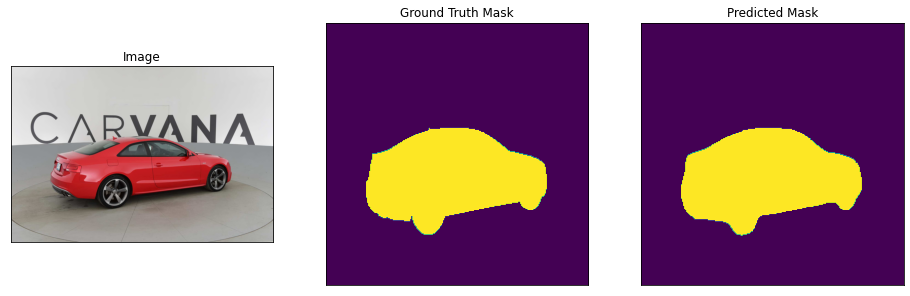

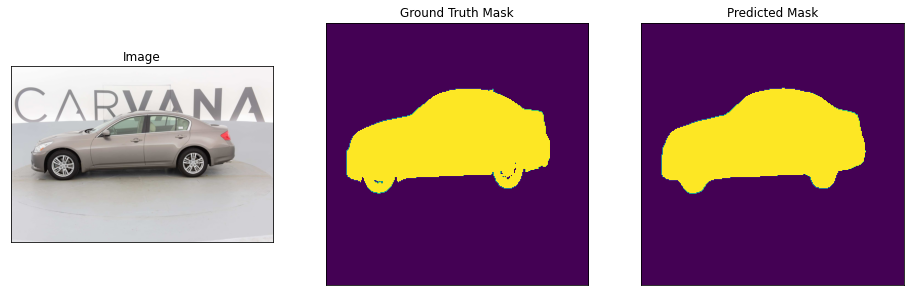

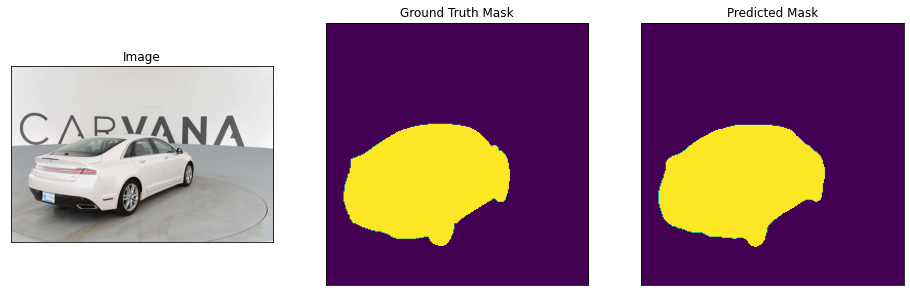

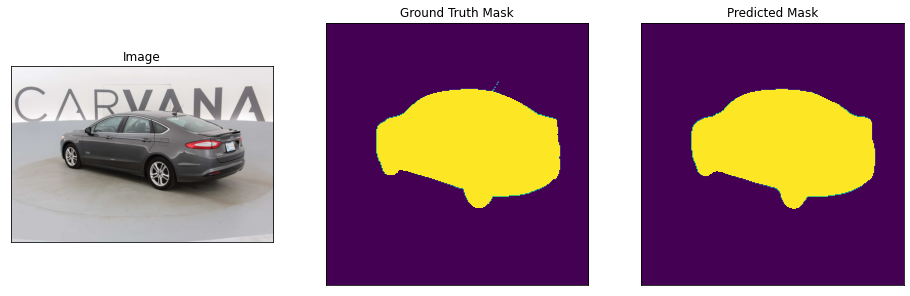

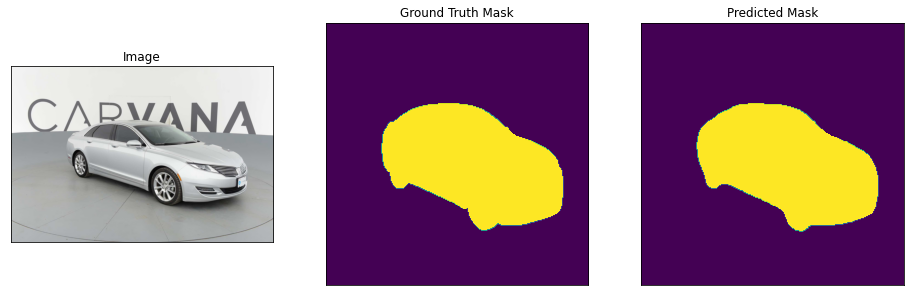

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

https://github.com/qubvel/segmentation_models

# Аугментации

In [ ]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)




def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        #RandomRotate90(),
        ElasticTransform(1.), 
        #HorizontalFlip(),
        #Cutout(p=1.),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.4),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=3),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.7),
         
        
        
    ],
        p=p)

In [ ]:
img = cv2.imread('prepod.jpg')
mask = cv2.imread('prepod_mak.jpg')

In [ ]:
plt.imshow(mask[..., 0])

TypeError: ignored

In [ ]:
plt.imshow(img[..., [2,1,0]])

TypeError: ignored

In [ ]:
img.shape

AttributeError: ignored

In [ ]:
augmentation = strong_aug(p=1.0)


data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
crop_img, crop_mask = augmented["image"], augmented["mask"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(crop_img[..., [2,1,0]])
axes[1].imshow(crop_mask)

plt.show()

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:290: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Embo

AttributeError: ignored

test-time augmentation


image_vis: (1280, 1918, 3)
image_original: (3, 256, 256)
gt_mask: (1, 256, 256)
image_flip: (3, 256, 256)
mask_flip: (1, 256, 256)
(1, 256, 256)
(256, 256)
x_tensor_original: torch.Size([1, 3, 256, 256])
x_tensor_flip: torch.Size([1, 3, 256, 256])
pr_mask_original: torch.Size([1, 1, 256, 256])
pr_mask_original: (1, 256, 256)
pr_mask_flip: torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pr_mask_flip_numpy: (1, 256, 256)
pr_mask_flip_flip: (1, 256, 256)
np.concatenate([pr_mask_original, pr_mask_flip_flip]): (2, 256, 256)
pr_mask_mean: (256, 256)


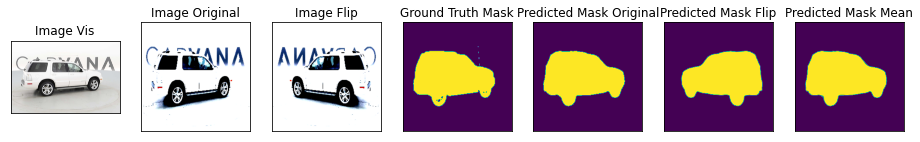

image_vis: (1280, 1918, 3)
image_original: (3, 256, 256)
gt_mask: (1, 256, 256)
image_flip: (3, 256, 256)
mask_flip: (1, 256, 256)
(1, 256, 256)
(256, 256)
x_tensor_original: torch.Size([1, 3, 256, 256])
x_tensor_flip: torch.Size([1, 3, 256, 256])
pr_mask_original: torch.Size([1, 1, 256, 256])
pr_mask_original: (1, 256, 256)
pr_mask_flip: torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pr_mask_flip_numpy: (1, 256, 256)
pr_mask_flip_flip: (1, 256, 256)
np.concatenate([pr_mask_original, pr_mask_flip_flip]): (2, 256, 256)
pr_mask_mean: (256, 256)


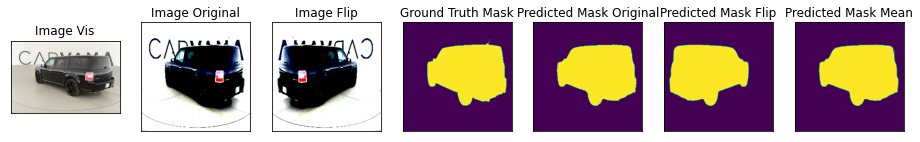

image_vis: (1280, 1918, 3)
image_original: (3, 256, 256)
gt_mask: (1, 256, 256)
image_flip: (3, 256, 256)
mask_flip: (1, 256, 256)
(1, 256, 256)
(256, 256)
x_tensor_original: torch.Size([1, 3, 256, 256])
x_tensor_flip: torch.Size([1, 3, 256, 256])
pr_mask_original: torch.Size([1, 1, 256, 256])
pr_mask_original: (1, 256, 256)
pr_mask_flip: torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pr_mask_flip_numpy: (1, 256, 256)
pr_mask_flip_flip: (1, 256, 256)
np.concatenate([pr_mask_original, pr_mask_flip_flip]): (2, 256, 256)
pr_mask_mean: (256, 256)


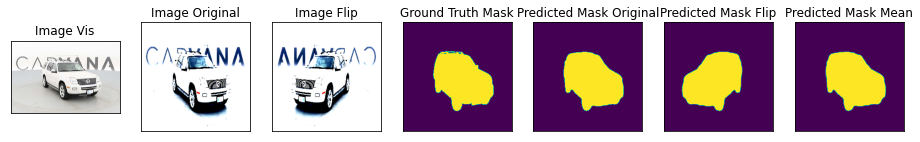

image_vis: (1280, 1918, 3)
image_original: (3, 256, 256)
gt_mask: (1, 256, 256)
image_flip: (3, 256, 256)
mask_flip: (1, 256, 256)
(1, 256, 256)
(256, 256)
x_tensor_original: torch.Size([1, 3, 256, 256])
x_tensor_flip: torch.Size([1, 3, 256, 256])
pr_mask_original: torch.Size([1, 1, 256, 256])
pr_mask_original: (1, 256, 256)
pr_mask_flip: torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pr_mask_flip_numpy: (1, 256, 256)
pr_mask_flip_flip: (1, 256, 256)
np.concatenate([pr_mask_original, pr_mask_flip_flip]): (2, 256, 256)
pr_mask_mean: (256, 256)


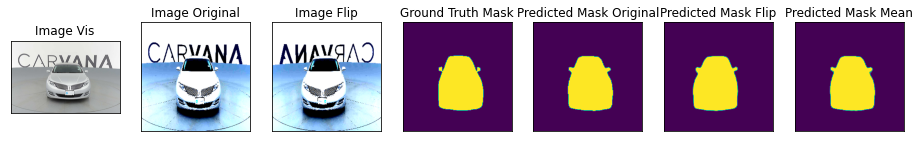

image_vis: (1280, 1918, 3)
image_original: (3, 256, 256)
gt_mask: (1, 256, 256)
image_flip: (3, 256, 256)
mask_flip: (1, 256, 256)
(1, 256, 256)
(256, 256)
x_tensor_original: torch.Size([1, 3, 256, 256])
x_tensor_flip: torch.Size([1, 3, 256, 256])
pr_mask_original: torch.Size([1, 1, 256, 256])
pr_mask_original: (1, 256, 256)
pr_mask_flip: torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pr_mask_flip_numpy: (1, 256, 256)
pr_mask_flip_flip: (1, 256, 256)
np.concatenate([pr_mask_original, pr_mask_flip_flip]): (2, 256, 256)
pr_mask_mean: (256, 256)


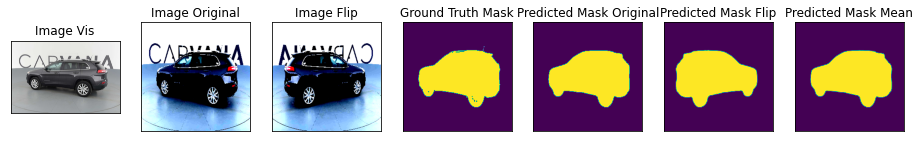

In [ ]:
verbose = False
device = 'cuda'

transform_flip = albu.HorizontalFlip(always_apply=True)

for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image_original, gt_mask = test_dataset[n]
    flip = transform_flip(image=image_original.transpose(1,2,0), mask=gt_mask.transpose(1,2,0))
    image_flip = flip['image'].transpose(2, 0, 1)
    mask_flip = flip['mask'].transpose(2, 0, 1)

    if verbose: print(f"image_vis: {image_vis.shape}")
    if verbose: print(f"image_original: {image_original.shape}")
    if verbose: print(f"gt_mask: {gt_mask.shape}")
    if verbose: print(f"image_flip: {image_flip.shape}")
    if verbose: print(f"mask_flip: {mask_flip.shape}")

    print(gt_mask.shape)
    gt_mask = gt_mask.squeeze()
    print(gt_mask.shape)
    
    x_tensor_original = torch.from_numpy(image_original).to(DEVICE).unsqueeze(0)
    if verbose: print(f"x_tensor_original: {x_tensor_original.shape}")

    x_tensor_flip = torch.from_numpy(image_flip).to(DEVICE).unsqueeze(0)
    if verbose: print(f"x_tensor_flip: {x_tensor_flip.shape}")

    pr_mask_original = best_model.predict(x_tensor_original)
    if verbose: print(f"pr_mask_original: {pr_mask_original.shape}")
    pr_mask_original = pr_mask_original.cpu().numpy().round().reshape(1, pr_mask_original.shape[2], pr_mask_original.shape[3])
    if verbose: print(f"pr_mask_original: {pr_mask_original.shape}")
        
    pr_mask_flip = best_model.predict(x_tensor_flip)
    if verbose: print(f"pr_mask_flip: {pr_mask_flip.shape}")
    pr_mask_flip_numpy = pr_mask_flip.cpu().numpy().reshape(1, pr_mask_flip.shape[2], pr_mask_flip.shape[3])
    if verbose: print(f"pr_mask_flip_numpy: {pr_mask_flip_numpy.shape}")

    pr_flip_flip = transform_flip(image=image_flip.transpose(1,2,0), mask=pr_mask_flip_numpy.transpose(1,2,0))
    pr_mask_flip_flip = pr_flip_flip['mask'].transpose(2, 0, 1)
    if verbose: print(f"pr_mask_flip_flip: {pr_mask_flip_flip.shape}")

    if verbose: print(f"np.concatenate([pr_mask_original, pr_mask_flip_flip]): {np.concatenate([pr_mask_original, pr_mask_flip_flip]).shape}")
    pr_mask_mean = np.concatenate([pr_mask_original, pr_mask_flip_flip]).mean(axis=(0))
    if verbose: print(f"pr_mask_mean: {pr_mask_mean.shape}")

    visualize(
        image_vis=image_vis, 
        image_original=image_original.transpose(1,2,0),
        image_flip=image_flip.transpose(1,2,0),
        ground_truth_mask=gt_mask, 
        predicted_mask_original=pr_mask_original.reshape(pr_mask_original.shape[1], pr_mask_original.shape[2]),
        predicted_mask_flip=pr_mask_flip_numpy.reshape(pr_mask_flip_numpy.shape[1], pr_mask_flip_numpy.shape[2]),
        predicted_mask_mean=pr_mask_mean,
    )

In [ ]:
def eval_model_flip(test_dataloader, model, criterion, metrics, verbose=False):

    transform_flip = albu.HorizontalFlip(p=1.0)

    val_loss_history = []
    val_metric_history = {}

    model.eval()
    print(f"\t\t eval...")

    with torch.no_grad():
        for (batch_idx, (data_batch, y_batch)) in enumerate(test_dataloader):
            print(f"\t\t\t batch:{batch_idx+1}/{len(test_dataloader)}...")

            assert(len(data_batch) == len(y_batch))
            for index_sample in range(len(data_batch)):

                data_original = data_batch[index_sample]
                data_original = data_original.to(device).float().unsqueeze(0)
                if verbose: print(f"data_original: {data_original.shape}")

                y_pred_original = model(data_original)
                if verbose: print(f"y_pred_original: {y_pred_original.shape}")
                y_pred_original = y_pred_original.cpu().numpy().round().reshape(1, y_pred_original.shape[2], y_pred_original.shape[3])
                if verbose: print(f"y_pred_original: {y_pred_original.shape}")

                data_flip = data_batch[index_sample]
                if verbose: print(f"data_flip: {data_flip.shape}")
                flip = transform_flip(image=data_flip.numpy().transpose(1,2,0))
                data_flip_numpy = flip['image']
                if verbose: print(f"data_flip_numpy: {data_flip_numpy.shape}")
                data_flip = torch.Tensor(data_flip_numpy.transpose(2, 0, 1)).to(device).float().unsqueeze(0)
                if verbose: print(f"data_flip: {data_flip.shape}")

                y_pred_flip = model(data_flip)
                if verbose: print(f"y_pred_flip: {y_pred_flip.shape}")
                y_pred_flip = y_pred_flip.reshape(1, y_pred_flip.shape[2], y_pred_flip.shape[3])
                if verbose: print(f"y_pred_flip: {y_pred_flip.shape}")                
                y_pred_flip_numpy = y_pred_flip.cpu().numpy()
                if verbose: print(f"y_pred_flip_numpy: {y_pred_flip_numpy.shape}")
                y_pred_flip_flip = transform_flip(image=data_flip_numpy, mask=y_pred_flip_numpy.transpose(1,2,0))                
                y_pred_flip_flip = y_pred_flip_flip['mask']
                if verbose: print(f"y_pred_flip_flip: {y_pred_flip_flip.shape}")
                y_pred_flip_flip = y_pred_flip_flip.transpose(2, 0, 1)          
                if verbose: print(f"y_pred_flip_flip: {y_pred_flip_flip.shape}")

                y_pred = np.concatenate([y_pred_original, y_pred_flip_flip]).mean(axis=(0))
                if verbose: print(f"y_pred: {y_pred.shape}")
                y_pred = torch.Tensor(y_pred).to(device).float().unsqueeze(0)
                if verbose: print(f"y_pred: {y_pred.shape}")

                y = y_batch[index_sample]
                y = y.to(device).float()
                if verbose: print(f"y: {y.shape}")

                loss = criterion(y_pred, y.float())

                val_loss_history.append(loss.item())

                for metric_current in metrics:
                    if metric_current not in val_metric_history:
                        val_metric_history[metric_current] = []
                    
                    metric_value = metric_current(y_pred, y.float())

                    val_metric_history[metric_current].append(metric_value.item())

    val_loss = np.mean(val_loss_history)
    print(f"val_loss={val_loss}")

    for metric_current in metrics:
        val_metric = np.mean(val_metric_history[metric_current])
        print(f"val_metric({str(metric_current)})={val_metric}")



In [ ]:
eval_model_flip(
    test_dataloader=test_loader, 
    model=best_model, 
    criterion=smp.utils.losses.DiceLoss(),
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
        # smp.utils.losses.BCELoss()
    ],
)


		 eval...
			 batch:1/272...
			 batch:2/272...
			 batch:3/272...
			 batch:4/272...
			 batch:5/272...
			 batch:6/272...
			 batch:7/272...
			 batch:8/272...
			 batch:9/272...
			 batch:10/272...
			 batch:11/272...
			 batch:12/272...
			 batch:13/272...
			 batch:14/272...
			 batch:15/272...
			 batch:16/272...
			 batch:17/272...
			 batch:18/272...
			 batch:19/272...
			 batch:20/272...
			 batch:21/272...
			 batch:22/272...
			 batch:23/272...
			 batch:24/272...
			 batch:25/272...
			 batch:26/272...
			 batch:27/272...
			 batch:28/272...
			 batch:29/272...
			 batch:30/272...
			 batch:31/272...
			 batch:32/272...
			 batch:33/272...
			 batch:34/272...
			 batch:35/272...
			 batch:36/272...
			 batch:37/272...
			 batch:38/272...
			 batch:39/272...
			 batch:40/272...
			 batch:41/272...
			 batch:42/272...
			 batch:43/272...
			 batch:44/272...
			 batch:45/272...
			 batch:46/272...
			 batch:47/272...
			 batch:48/272...
			 batch:49/272...
			 batch:50/272..

# Задание (10 баллов)

##fist_task

In [24]:
upd_new_model_bn = nn.Sequential(
    nn.Conv2d(3, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(32, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(64, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(128, 256, (3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, (3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(256, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, (3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(128, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, (3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(64, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, (3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    
    nn.UpsamplingBilinear2d(scale_factor=2),
    nn.Conv2d(32, 1, (3, 3), padding=1),
    nn.BatchNorm2d(1),
    nn.Dropout(),
    nn.ReLU(),
    nn.Conv2d(1, 1, (3, 3), padding=1)
    )

In [25]:
train_dataloader = DataLoader(SegDataset(train_df), batch_size=32, num_workers=2, drop_last=True)
test_dataloader = DataLoader(SegDataset(val_df), batch_size=32, num_workers=2, drop_last=True)

In [26]:
optimizer = torch.optim.Adam(upd_new_model_bn.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

if torch.cuda.is_available():
    upd_new_model_bn.to('cuda')

In [27]:
scaler = torch.cuda.amp.GradScaler()
for epoch in range(5):
    upd_new_model_bn.train()
    for (batch_idx, (data, y)) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            data = data.to('cuda').float()
            y = y.to('cuda').float()

        optimizer.zero_grad()

        # Casts operations to mixed precision
        with torch.cuda.amp.autocast():
            ypred = upd_new_model_bn(data)
            loss = criterion(ypred, y)

        # Scales the loss, and calls backward()
        # to create scaled gradients
#             loss.backward()
        scaler.scale(loss).backward()

        # Unscales gradients and calls
        # or skips optimizer.step()
#             optimizer.step()
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()

    print(f"EPOCH {epoch}, Train Loss: {loss.item()}")
    
    if test_dataloader is not None:
        upd_new_model_bn.eval()
        with torch.no_grad():
            for (batch_idx, (data, y)) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    data = data.to('cuda:0').float()
                    y = y.to('cuda:0').float()
                
                with torch.cuda.amp.autocast():
                    ypred = upd_new_model_bn(data)
                    loss = criterion(ypred, y)
    
    print(f"EPOCH {epoch}, Test Loss: {loss.item()}")

EPOCH 0, Train Loss: 0.20885880291461945
EPOCH 0, Test Loss: 0.2144986391067505
EPOCH 1, Train Loss: 0.13717059791088104
EPOCH 1, Test Loss: 0.14093109965324402
EPOCH 2, Train Loss: 0.10057114064693451
EPOCH 2, Test Loss: 0.09780613332986832
EPOCH 3, Train Loss: 0.08216608315706253
EPOCH 3, Test Loss: 0.07346540689468384
EPOCH 4, Train Loss: 0.06520073115825653
EPOCH 4, Test Loss: 0.0786299929022789


In [28]:
pred = upd_new_model_bn(data.float().to('cuda'))

In [29]:
pred = pred.detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


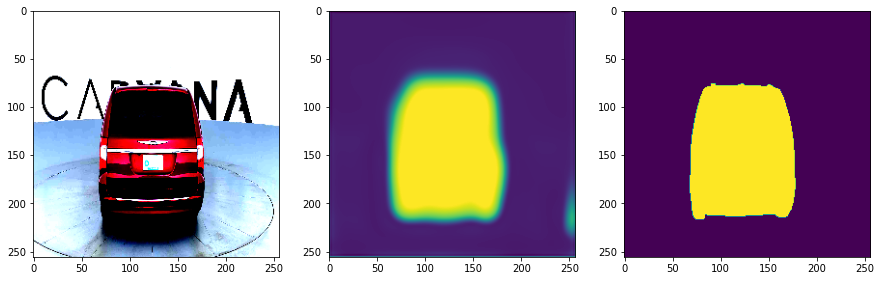

In [30]:
im_id = 8
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(data[im_id].detach().cpu().numpy().astype(float).transpose((1, 2, 0)))
axes[1].imshow((pred[im_id]).transpose(1, 2, 0).reshape(256, -1))
axes[2].imshow((y[im_id].detach().cpu().numpy()).transpose(1, 2, 0).reshape(256, -1))

plt.show()

##second_task

In [31]:
!pip install -U segmentation-models-pytorch albumentations

     |████████████████████████████████| 88 kB 8.4 MB/s 
     |████████████████████████████████| 102 kB 71.3 MB/s 
     |████████████████████████████████| 376 kB 58.7 MB/s 
     |████████████████████████████████| 58 kB 8.9 MB/s 
     |████████████████████████████████| 47.8 MB 56.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=36b376a4cd26f3824e895eaacecb3f75d553fbb9592b4de95275976c48a0158c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8a5186691a07b63026aff94b653703a0e672026ea371fb8bde996633cc06083c
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12


In [32]:
import albumentations as albu

In [33]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(height=256, width=256, always_apply=True),

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(height=256, width=256, always_apply=True),
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [34]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.shape[2]>1:
          plt.imshow(image.reshape(256, 256, -1))
        else:
          plt.imshow(image.reshape(256, 256))
    plt.show()

In [35]:
class SegDataset(Dataset):
    def __init__(
            self, 
            dataset, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.dataset = dataset
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # read data
        img_name, mask_rle = self.dataset.iloc[i].values
        image = cv2.imread('data/train/{}'.format(img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = rle_decode(mask_rle)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.dataset)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

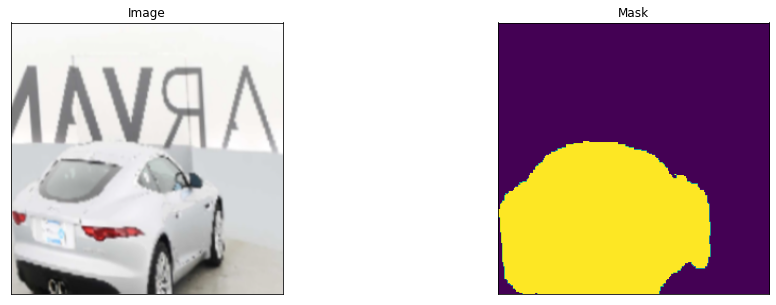

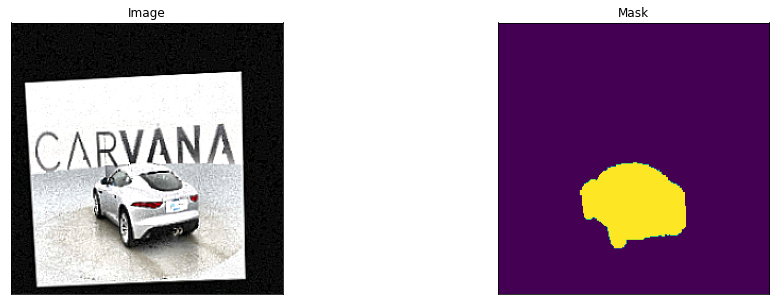

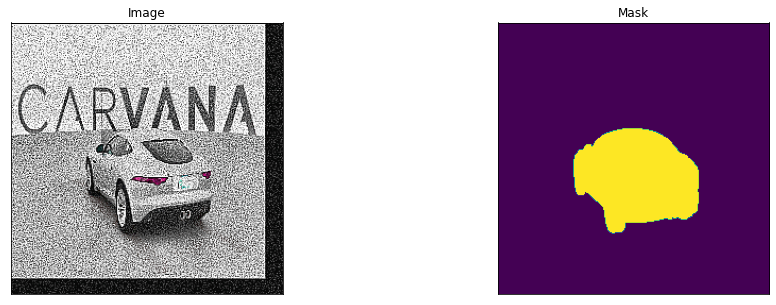

In [36]:
augmented_dataset = SegDataset(
    train_df, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[55]
    visualize(image=image, mask=mask)

In [37]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [38]:
ENCODER = 'densenet121'  
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1,
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth


  0%|          | 0.00/30.9M [00:00<?, ?B/s]

In [39]:
train_dataset = SegDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)
test_dataset = SegDataset(
    val_df, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

In [40]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [41]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [42]:
# train model for 10 epochs
max_score = 0

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 272/272 [00:34<00:00,  7.93it/s, dice_loss - 0.05127, iou_score - 0.9704]
Model saved!

Epoch: 1
valid: 100%|██████████| 272/272 [00:34<00:00,  7.87it/s, dice_loss - 0.02372, iou_score - 0.9757]
Model saved!

Epoch: 2
valid: 100%|██████████| 272/272 [00:33<00:00,  8.01it/s, dice_loss - 0.01667, iou_score - 0.9785]
Model saved!

Epoch: 3
valid: 100%|██████████| 272/272 [00:34<00:00,  7.98it/s, dice_loss - 0.01503, iou_score - 0.9778]

Epoch: 4
valid: 100%|██████████| 272/272 [00:34<00:00,  7.96it/s, dice_loss - 0.01251, iou_score - 0.9796]
Model saved!

Epoch: 5
valid: 100%|██████████| 272/272 [00:33<00:00,  8.02it/s, dice_loss - 0.01087, iou_score - 0.9816]
Model saved!

Epoch: 6
valid: 100%|██████████| 272/272 [00:34<00:00,  7.85it/s, dice_loss - 0.01136, iou_score - 0.9799]

Epoch: 7
valid: 100%|██████████| 272/272 [00:34<00:00,  7.97it/s, dice_loss - 0.01124, iou_score - 0.9797]

Epoch: 8
valid: 100%|██████████| 272/272 [00:34<00:00,  7.95it/s, dice

In [43]:
best_model = torch.load('./best_model.pth')

In [44]:
# test dataset without transformations for image visualization
test_dataset_vis = SegDataset(
    val_df
)

In [45]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

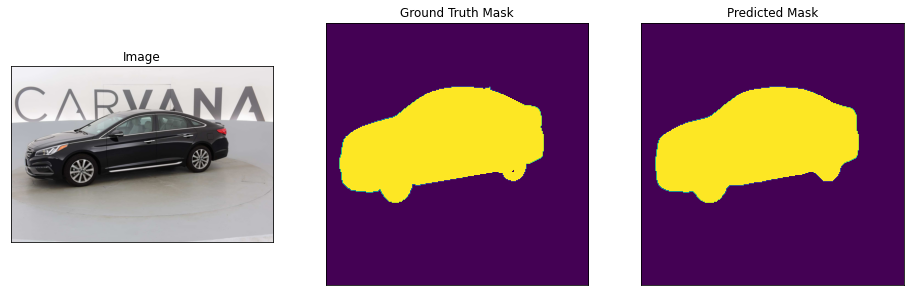

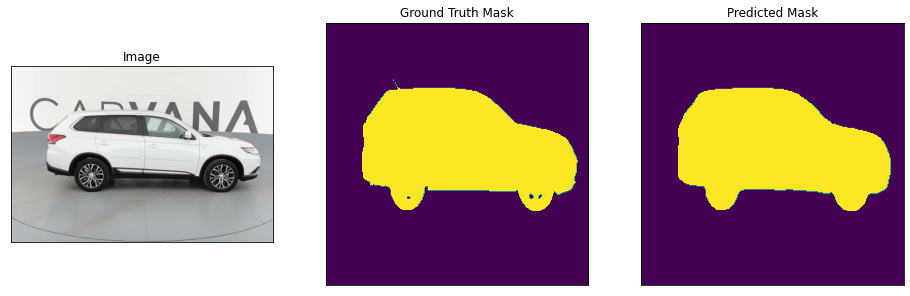

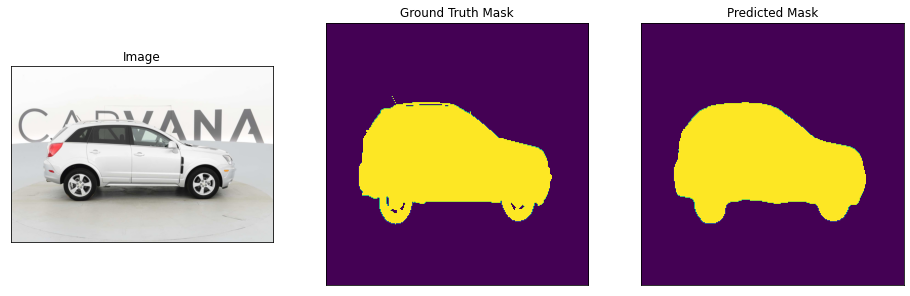

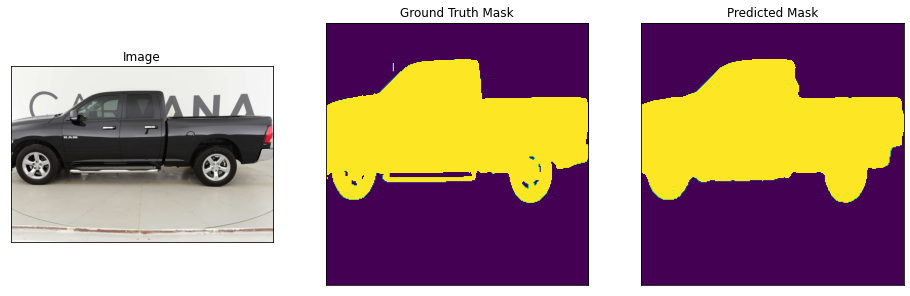

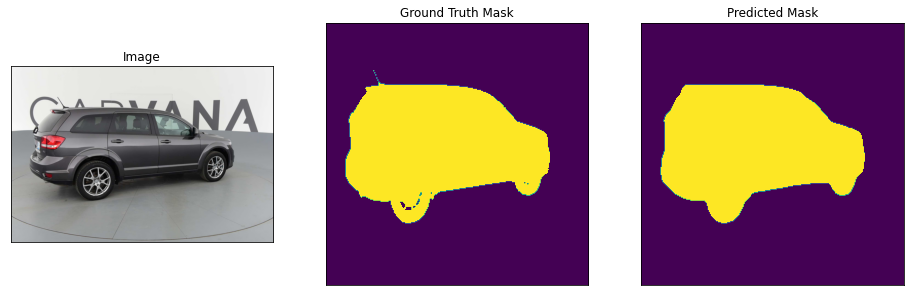

In [46]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [49]:
def eval_model_flip(test_dataloader, model, criterion, metrics, verbose=False):

    transform_flip = albu.HorizontalFlip(p=1.0)

    val_loss_history = []
    val_metric_history = {}

    model.eval()
    print(f"\t\t eval...")

    with torch.no_grad():
        for (batch_idx, (data_batch, y_batch)) in enumerate(test_dataloader):
            print(f"\t\t\t batch:{batch_idx+1}/{len(test_dataloader)}...")

            assert(len(data_batch) == len(y_batch))
            for index_sample in range(len(data_batch)):

                data_original = data_batch[index_sample]
                data_original = data_original.to(device).float().unsqueeze(0)
                if verbose: print(f"data_original: {data_original.shape}")

                y_pred_original = model(data_original)
                if verbose: print(f"y_pred_original: {y_pred_original.shape}")
                y_pred_original = y_pred_original.cpu().numpy().round().reshape(1, y_pred_original.shape[2], y_pred_original.shape[3])
                if verbose: print(f"y_pred_original: {y_pred_original.shape}")

                data_flip = data_batch[index_sample]
                if verbose: print(f"data_flip: {data_flip.shape}")
                flip = transform_flip(image=data_flip.numpy().transpose(1,2,0))
                data_flip_numpy = flip['image']
                if verbose: print(f"data_flip_numpy: {data_flip_numpy.shape}")
                data_flip = torch.Tensor(data_flip_numpy.transpose(2, 0, 1)).to(device).float().unsqueeze(0)
                if verbose: print(f"data_flip: {data_flip.shape}")

                y_pred_flip = model(data_flip)
                if verbose: print(f"y_pred_flip: {y_pred_flip.shape}")
                y_pred_flip = y_pred_flip.reshape(1, y_pred_flip.shape[2], y_pred_flip.shape[3])
                if verbose: print(f"y_pred_flip: {y_pred_flip.shape}")                
                y_pred_flip_numpy = y_pred_flip.cpu().numpy()
                if verbose: print(f"y_pred_flip_numpy: {y_pred_flip_numpy.shape}")
                y_pred_flip_flip = transform_flip(image=data_flip_numpy, mask=y_pred_flip_numpy.transpose(1,2,0))                
                y_pred_flip_flip = y_pred_flip_flip['mask']
                if verbose: print(f"y_pred_flip_flip: {y_pred_flip_flip.shape}")
                y_pred_flip_flip = y_pred_flip_flip.transpose(2, 0, 1)          
                if verbose: print(f"y_pred_flip_flip: {y_pred_flip_flip.shape}")

                y_pred = np.concatenate([y_pred_original, y_pred_flip_flip]).mean(axis=(0))
                if verbose: print(f"y_pred: {y_pred.shape}")
                y_pred = torch.Tensor(y_pred).to(device).float().unsqueeze(0)
                if verbose: print(f"y_pred: {y_pred.shape}")

                y = y_batch[index_sample]
                y = y.to(device).float()
                if verbose: print(f"y: {y.shape}")

                loss = criterion(y_pred, y.float())

                val_loss_history.append(loss.item())

                for metric_current in metrics:
                    if metric_current not in val_metric_history:
                        val_metric_history[metric_current] = []
                    
                    metric_value = metric_current(y_pred, y.float())

                    val_metric_history[metric_current].append(metric_value.item())

    val_loss = np.mean(val_loss_history)
    print(f"val_loss={val_loss}")

    for metric_current in metrics:
        val_metric = np.mean(val_metric_history[metric_current])
        print(f"val_metric({str(metric_current)})={val_metric}")

In [50]:
device = 'cuda'

eval_model_flip(
    test_dataloader=test_loader, 
    model=best_model, 
    criterion=smp.utils.losses.DiceLoss(),
    metrics = [
        smp.utils.metrics.IoU(threshold=0.5),
        # smp.utils.losses.BCELoss()
    ],
)

		 eval...
			 batch:1/272...
			 batch:2/272...
			 batch:3/272...
			 batch:4/272...
			 batch:5/272...
			 batch:6/272...
			 batch:7/272...
			 batch:8/272...
			 batch:9/272...
			 batch:10/272...
			 batch:11/272...
			 batch:12/272...
			 batch:13/272...
			 batch:14/272...
			 batch:15/272...
			 batch:16/272...
			 batch:17/272...
			 batch:18/272...
			 batch:19/272...
			 batch:20/272...
			 batch:21/272...
			 batch:22/272...
			 batch:23/272...
			 batch:24/272...
			 batch:25/272...
			 batch:26/272...
			 batch:27/272...
			 batch:28/272...
			 batch:29/272...
			 batch:30/272...
			 batch:31/272...
			 batch:32/272...
			 batch:33/272...
			 batch:34/272...
			 batch:35/272...
			 batch:36/272...
			 batch:37/272...
			 batch:38/272...
			 batch:39/272...
			 batch:40/272...
			 batch:41/272...
			 batch:42/272...
			 batch:43/272...
			 batch:44/272...
			 batch:45/272...
			 batch:46/272...
			 batch:47/272...
			 batch:48/272...
			 batch:49/272...
			 batch:50/272..